In [12]:
import tensorflow as tf

print("TensorFlow Version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.10.0
Is built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
import tensorflow as tf

# Check if TensorFlow was built with GPU support
print("Is TensorFlow built with CUDA:", tf.test.is_built_with_cuda())

# List available GPUs
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Check if TensorFlow can use the GPU
print("Is GPU being used:", len(tf.config.list_physical_devices('GPU')) > 0)


Is TensorFlow built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU being used: True


In [13]:
import os
import pickle
import numpy as np
from pathlib import Path

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## EXTRACT IMAGE FEATURES

In [ ]:
model = VGG16()
# restructure the model

model = Model(inputs = model.inputs,outputs=model.layers[-2].output)

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Extract features from Image
from PIL import Image
features = {}
directory = r"E:\projects\Image captioning\data\Images" 

list_dir = os.listdir(directory)

for num,img in enumerate(list_dir):
    img_path = os.path.join(directory, img)
    image = load_img(img_path,target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image)
    image_id = img.split('.')[0]
    features[image_id] = feature
    print(num)

1/1 [==============================] - 27s 27s/step
0
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 21ms/step
2
1/1 [==============================] - 0s 23ms/step
3
1/1 [==============================] - 0s 11ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 21ms/step
6
1/1 [==============================] - 0s 18ms/step
7
1/1 [==============================] - 0s 17ms/step
8
1/1 [==============================] - 0s 14ms/step
9
1/1 [==============================] - 0s 21ms/step
10
1/1 [==============================] - 0s 16ms/step
11
1/1 [==============================] - 0s 15ms/step
12
1/1 [==============================] - 0s 20ms/step
13
1/1 [==============================] - 0s 21ms/step
14
1/1 [==============================] - 0s 18ms/step
15
1/1 [==============================] - 0s 16ms/step
16
1/1 [==============================] - 0s 23ms/step
17
1/1 [===============

In [22]:
pickle.dump(features,open(os.path.join(os.getcwd(),'features.pkl'),'wb'))

# Loading features and captions of images

In [14]:
features_path = r'E:\projects\Image captioning\experiments\features.pkl'
captions_path = r"E:\projects\Image captioning\data\captions.txt"

In [15]:

with open(features_path, 'rb') as file:
    features = pickle.load(file)
with open(captions_path, "rb") as file:
    captions = file.read()
    captions = captions.decode("utf-8") 

In [16]:
mapping = {}
for line in captions.split("\n"):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]

    image_id = image_id.split('.')[0]

    caption = " ".join(caption)

    if image_id not in mapping:
        mapping[image_id]  = []
    mapping[image_id].append(caption)


In [17]:
len(mapping)

8092

# Preprocess text data

In [18]:
del mapping["image"]


In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            
            caption = captions[i]

            caption = caption.lower()

            caption = caption.replace("[^A-Za-z]",'')

            caption = caption.replace('\s+',' ')

            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
clean(mapping)

In [22]:
mapping

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tri-colored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

In [23]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [24]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [25]:
len(all_captions)

40455

In [26]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

8485

In [29]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [30]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [31]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [32]:
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 41s 180ms/step - loss: 2.1929


In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in (test):

    captions = mapping[key]

    y_pred = predict_caption(model, features[key], tokenizer, max_length) 

    actual_captions = [caption.split() for caption in captions]

    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.547489
BLEU-2: 0.312593


In [44]:
from PIL import Image
import matplotlib.pyplot as plt
directory = r"E:\projects\Image captioning\data\Images" 

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the grass endseq


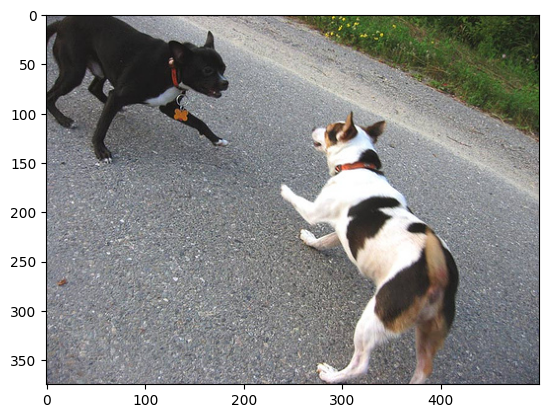

In [45]:
generate_caption("1001773457_577c3a7d70.jpg")


---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pink dress and green hat is clinging to fingerpaints endseq


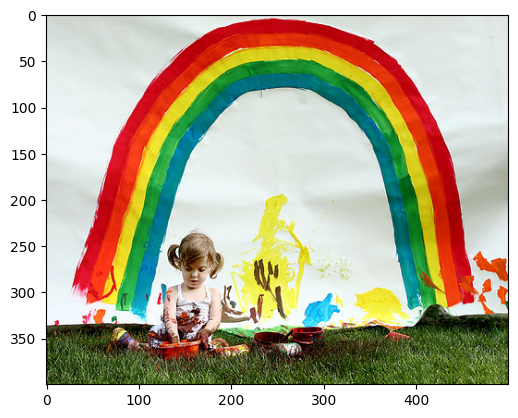

In [46]:
generate_caption("1002674143_1b742ab4b8.jpg")


In [50]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [54]:
image_path = r"C:\Users\gomes\Downloads\An-Indian-boy-375075-pixahive.webp"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq boy in blue and black shorts is sitting on the grass endseq'